In [1]:
import re
import os
import numpy as np
import pandas as pd
import random
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
from mllib.model import KerasSurrogate

In [2]:
from Pymiescatt_forward import *

In [3]:
class AdjustedRSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the adjusted R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquaredSeparated().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquaredSeparated(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [4]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2

In [5]:
class AdjustedRSquared(tf.keras.losses.Loss):
    '''
    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquared().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)
        adjusted_r2 = tf.math.reduce_mean(adjusted_r2)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquared(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

Median radius ~ 400 nm
Ln(GSD) ~ 0.262
V ~ 24.5 um3/cc
DEHS particles (refractive index = 1.45 + 1e-5i at 532 nm)

These results are for different median size cases, namely, 200 nm, 400 nm, 600 nm and 800 nm. I included another CSV file that has the average number concentration with unit of #/cc. The GSD for these experiment are not exactly known but it is most likely between 1.05 to 1.1. Note that the unit for phase function is 1/Mm 1/str.

n addition to these narrow phase function data, I included another CSV file that has the phase function for a measurement conducted for broad size distribution with median size of 400 nm and GSD 1.4. This could already be included in the current ML model as its GSD is within the training range. Note that both phase function (P11) and polarized phase function (PPF) are include in the same csv file for the broad 400 nm data.
 
 

In [6]:
np.exp(0.262)

1.2995265424293818

# Open Data

In [7]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

In [8]:
directory1 = '/data/project/general/aerosolretriev'

In [9]:
#plot_dir = directory1 + 'version13/plots/measurement_data'
#if not os.path.exists(plot_dir):
#    os.makedirs(plot_dir)



In [10]:
#model_dir = '/data/project/general/aerosolretriev/aerosol_results_ds08/aerosol_results_11_09_2022/forward_model2/models/forward_model'


#model_dir = '/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_models/forward_model08/forward_id/train_forward_model_6634c_00000_0_2022-09-22_08-54-27'
#model_dir = '/data/project/general/aerosolretriev/aerosol_results_october_2022/invertible_model3/models'
#model_dir = '/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_model8'
#model_dir = '/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_model0/forward_model4'
#model_dir = '/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_models/forward_model08'
#model_dir = '/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_model0_1/forward_model1'
#model_dir = '/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_model0/forward_model0/forward_id/train_forward_model_ce069_00000_0_2022-09-22_13-43-41'
model_dir = '/data/project/general/aerosolretriev/aerosol_results_september_2022/forward_model0_0/forward_model0'




In [11]:
custom_objects = {
    'AdjustedRSquared': AdjustedRSquared,
}

kwargs = {
    'custom_objects': custom_objects,
    'compile': False,
}
model_name = 'model'

custom_objects = {'AdjustedRSquared': AdjustedRSquared}

kwargs = {'custom_objects': custom_objects,'compile': False}

surr = KerasSurrogate.load(model_dir,model_name, model_kwargs=kwargs)

#surr = InvertibleNetworkSurrogate.load(model_dir, model_name, model_kwargs=kwargs)

In [12]:

#surr = keras.models.load_model(model_dir)


#Load test data

In [13]:
test_datafile = directory1 +'/aerosol_data/dataset_15_08_2022/data/data_test_trunc_fw.h5'
dvar_test = pd.read_hdf(test_datafile,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')


Real measurement data

In [14]:
data_dir = '/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_Alireza_Phdthesis'

#phase_fun400_old = pd.read_csv(data_dir2+"/uNeph_PF_400nm_broad.csv")
#num_con = pd.read_csv(data_dir1+"/number_concentration.csv")
phase_fun_meas = pd.read_csv(data_dir+"/df_p11_ppf_uNeph.csv")
phase_fun_GRASP_inv = pd.read_csv(data_dir+"/df_p11_ppf_grasp.csv")
vol_size_GRASP_bin = pd.read_csv(data_dir+"/df_psd_grasp_binned.csv")
vol_size_GRASP_log = pd.read_csv(data_dir+"/df_psd_grasp_lognorm.csv")
vol_size_meas = pd.read_csv(data_dir+"/df_psd_smps.csv")
meas_param = pd.read_csv(data_dir+"/df_measured_and_retreived_psd_properties.csv")
#phase_fun400_bin = pd.read_csv(data_dir+"/df_PF_Grasp_binned_P11P12_1wl.csv")

#data_real_old = pd.read_csv(data_dir2+"/uNeph_GRASP_data.csv")

#"/data/project/general/aerosolretriev/aerosol_data/real_measurement_data_november2021/df_PF_Grasp_binned_P11P12_1wl.csv"



#phase_fun400_log = pd.read_csv(data_dir+"/df_PF_Grasp_lognorm_P11P12_1wl.csv")

#phase_funexp = pd.read_csv(data_dir+"/phase_function_experimental_data.csv")
#phase_funP11 = pd.read_csv(data_dir+"/phase_function_P11.csv")
#phase_funpolar = pd.read_csv(data_dir+'/polar_phase_function.csv')

In [15]:
phase_fun_meas.head(12)

angles         P11       PPF
0    2.958415         NaN       NaN
1    3.939364         NaN       NaN
2    4.917770  183.301344  0.000434
3    5.893669  188.270193 -0.016319
4    6.867099  211.998636  0.017256
5    7.838099         NaN       NaN
6    8.806713         NaN       NaN
7    9.772985         NaN       NaN
8   10.736964         NaN       NaN
9   11.698698  173.001017  0.047280
10  12.658239  167.585850  0.030640
11  13.615641  165.624263  0.009350

In [16]:
phase_fun_GRASP_inv

angle  P11_Binned (0.05-15$\mu$m)_P11P12  \
0     11.698698                         184.723185   
1     12.658239                         179.542691   
2     13.615641                         174.346282   
3     16.475578                         157.690718   
4     17.424998                         151.905435   
..          ...                                ...   
151  165.388185                           2.294616   
152  166.410092                           2.346023   
153  167.435464                           2.398624   
154  168.464287                           2.451782   
155  169.496541                           2.504621   

     PPF_Binned (0.05-15$\mu$m)_P11P12  P11_Binned (0.05-15$\mu$m)_P11  \
0                             0.002964                      182.797410   
1                             0.003433                      176.351635   
2                             0.003926                      170.120719   
3                             0.005515                      151.682619   
4                             0.006071                      145.730224   
..                                 ...                             ...   
151                          -0.239340                        2.482260   
152                          -0.211780                        2.491332   
153                          -0.184640                        2.501677   
154                          -0.158310                        2.515523   
155                          -0.133180                        2.535020   

     P11_lognormal (0.05-15$\mu$m)_P11P12  \
0                              187.046847   
1                              181.643537   
2                              176.224311   
3                              158.916211   
4                              152.908112   
..                                    ...   
151                              2.304802   
152                              2.356528   
153                              2.409685   
154                              2.463639   
155                              2.517592   

     PPF_lognormal (0.05-15$\mu$m)_P11P12  P11_lognormal (0.05-15$\mu$m)_P11  
0                                0.002702                         186.227199  
1                                0.003125                         180.911424  
2                                0.003571                         175.579733  
3                                0.005000                         158.510366  
4                                0.005496                         152.581844  
..                                    ...                                ...  
151                             -0.246980                           2.299709  
152                             -0.218910                           2.351355  
153                             -0.191120                           2.404433  
154                             -0.164070                           2.458148  
155                             -0.138160                           2.511624  

[156 rows x 7 columns]

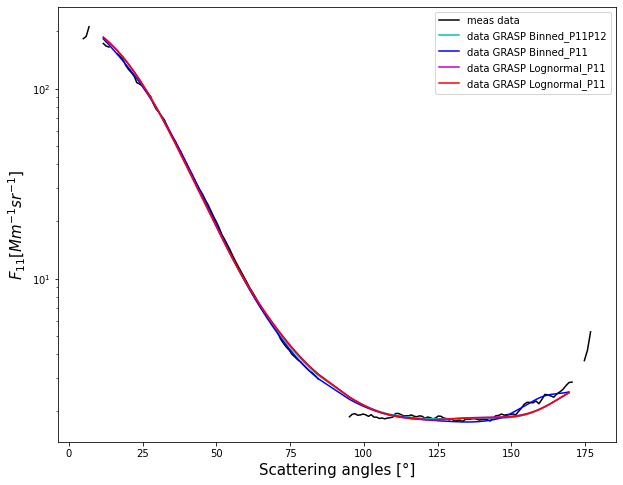

In [17]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['P11'],'k',label = 'meas data')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11'],'b',label = 'data GRASP Binned_P11')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11'],'r',label = 'data GRASP Lognormal_P11')


plt.yscale('log')

plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('$F_{11} [Mm^{-1}sr^{-1}$]', fontsize = fontsize1)
plt.legend()


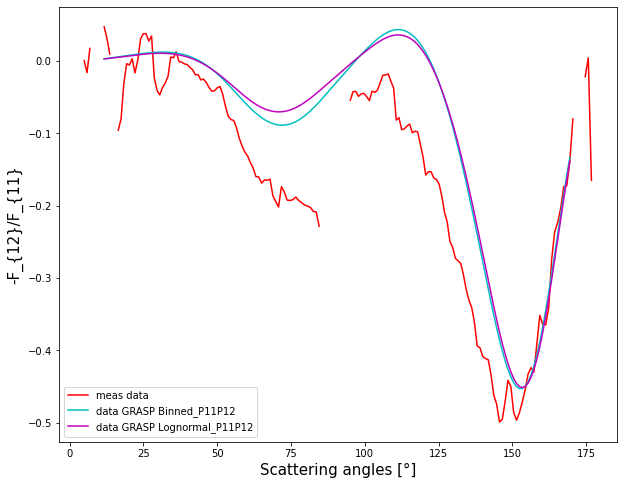

In [18]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['PPF'],'r',label = 'meas data')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11P12')


plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('-F_{12}/F_{11}', fontsize = fontsize1)
plt.legend()

# transform real measurement data to right format

In [19]:
# First step: interpolate the angles

In [20]:
from scipy.interpolate import interp1d

In [21]:
phase_fun_meas['angles'].max()

176.8157278691418

In [22]:
f_11 = interp1d(phase_fun_meas['angles'],phase_fun_meas['P11'])
f_PPF = interp1d(phase_fun_meas['angles'],phase_fun_meas['PPF'])
#f_11_GRASP = interp1d(data_real['angles'],data_real['P11_GRASP_lognorm'])
#f_12_GRASP = interp1d(data_real['angles'],data_real['PPF_GRASP_lognorm'])

In [23]:
angles_meas_new = np.linspace(3,176,num = 174,endpoint = True)
angles_meas_new

array([  3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  13.,
        14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,  22.,  23.,  24.,
        25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,  33.,  34.,  35.,
        36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,  44.,  45.,  46.,
        47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,
        58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,
        69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.,
        80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.,  90.,
        91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99., 100., 101.,
       102., 103., 104., 105., 106., 107., 108., 109., 110., 111., 112.,
       113., 114., 115., 116., 117., 118., 119., 120., 121., 122., 123.,
       124., 125., 126., 127., 128., 129., 130., 131., 132., 133., 134.,
       135., 136., 137., 138., 139., 140., 141., 142., 143., 144., 145.,
       146., 147., 148., 149., 150., 151., 152., 15

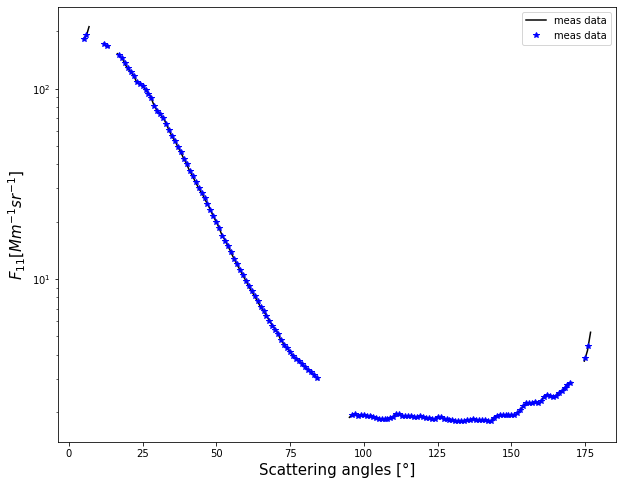

In [24]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['P11'],'k',label = 'meas data')
plt.plot(angles_meas_new,f_11(angles_meas_new),'b*',label = 'meas data')

#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11'],'b',label = 'data GRASP Binned_P11')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11'],'r',label = 'data GRASP Lognormal_P11')


plt.yscale('log')

plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('$F_{11} [Mm^{-1}sr^{-1}$]', fontsize = fontsize1)
plt.legend()


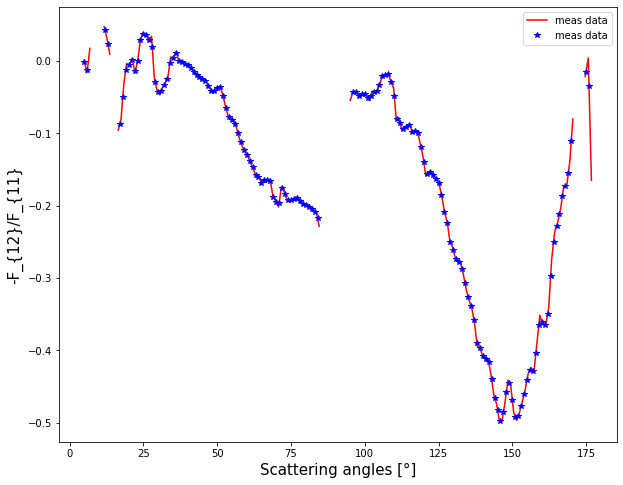

In [25]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['PPF'],'r',label = 'meas data')
plt.plot(angles_meas_new,f_PPF(angles_meas_new),'b*',label = 'meas data')

#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11P12')


plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('-F_{12}/F_{11}', fontsize = fontsize1)
plt.legend()

In [26]:
# Bringing the data in the right format

In [27]:
phase_fun_meas_form_F11 = pd.DataFrame(data = f_11(angles_meas_new)).transpose()
phase_fun_meas_form_PPF = pd.DataFrame(data = f_PPF(angles_meas_new)).transpose()


In [28]:
# Rename the columns
listindex_data1 = []
listindex_data2 = []
for i in range(len(angles_meas_new)):
    listindex_data1.append("F11_"+str(int(angles_meas_new[i])))
    listindex_data2.append("PPF_"+str(int(angles_meas_new[i])))

In [29]:
listindex_data1

['F11_3',
 'F11_4',
 'F11_5',
 'F11_6',
 'F11_7',
 'F11_8',
 'F11_9',
 'F11_10',
 'F11_11',
 'F11_12',
 'F11_13',
 'F11_14',
 'F11_15',
 'F11_16',
 'F11_17',
 'F11_18',
 'F11_19',
 'F11_20',
 'F11_21',
 'F11_22',
 'F11_23',
 'F11_24',
 'F11_25',
 'F11_26',
 'F11_27',
 'F11_28',
 'F11_29',
 'F11_30',
 'F11_31',
 'F11_32',
 'F11_33',
 'F11_34',
 'F11_35',
 'F11_36',
 'F11_37',
 'F11_38',
 'F11_39',
 'F11_40',
 'F11_41',
 'F11_42',
 'F11_43',
 'F11_44',
 'F11_45',
 'F11_46',
 'F11_47',
 'F11_48',
 'F11_49',
 'F11_50',
 'F11_51',
 'F11_52',
 'F11_53',
 'F11_54',
 'F11_55',
 'F11_56',
 'F11_57',
 'F11_58',
 'F11_59',
 'F11_60',
 'F11_61',
 'F11_62',
 'F11_63',
 'F11_64',
 'F11_65',
 'F11_66',
 'F11_67',
 'F11_68',
 'F11_69',
 'F11_70',
 'F11_71',
 'F11_72',
 'F11_73',
 'F11_74',
 'F11_75',
 'F11_76',
 'F11_77',
 'F11_78',
 'F11_79',
 'F11_80',
 'F11_81',
 'F11_82',
 'F11_83',
 'F11_84',
 'F11_85',
 'F11_86',
 'F11_87',
 'F11_88',
 'F11_89',
 'F11_90',
 'F11_91',
 'F11_92',
 'F11_93',
 'F11_

In [30]:
dicts_data_1 = {}
j = 0
for i in phase_fun_meas_form_F11.columns:
    dicts_data_1[i]=listindex_data1[j]
    j=j+1
dicts_data_2 = {}
j = 0
for i in phase_fun_meas_form_PPF.columns:
    dicts_data_2[i]=listindex_data2[j]
    j=j+1

In [31]:
dicts_data_1

{0: 'F11_3',
 1: 'F11_4',
 2: 'F11_5',
 3: 'F11_6',
 4: 'F11_7',
 5: 'F11_8',
 6: 'F11_9',
 7: 'F11_10',
 8: 'F11_11',
 9: 'F11_12',
 10: 'F11_13',
 11: 'F11_14',
 12: 'F11_15',
 13: 'F11_16',
 14: 'F11_17',
 15: 'F11_18',
 16: 'F11_19',
 17: 'F11_20',
 18: 'F11_21',
 19: 'F11_22',
 20: 'F11_23',
 21: 'F11_24',
 22: 'F11_25',
 23: 'F11_26',
 24: 'F11_27',
 25: 'F11_28',
 26: 'F11_29',
 27: 'F11_30',
 28: 'F11_31',
 29: 'F11_32',
 30: 'F11_33',
 31: 'F11_34',
 32: 'F11_35',
 33: 'F11_36',
 34: 'F11_37',
 35: 'F11_38',
 36: 'F11_39',
 37: 'F11_40',
 38: 'F11_41',
 39: 'F11_42',
 40: 'F11_43',
 41: 'F11_44',
 42: 'F11_45',
 43: 'F11_46',
 44: 'F11_47',
 45: 'F11_48',
 46: 'F11_49',
 47: 'F11_50',
 48: 'F11_51',
 49: 'F11_52',
 50: 'F11_53',
 51: 'F11_54',
 52: 'F11_55',
 53: 'F11_56',
 54: 'F11_57',
 55: 'F11_58',
 56: 'F11_59',
 57: 'F11_60',
 58: 'F11_61',
 59: 'F11_62',
 60: 'F11_63',
 61: 'F11_64',
 62: 'F11_65',
 63: 'F11_66',
 64: 'F11_67',
 65: 'F11_68',
 66: 'F11_69',
 67: 'F11_70

In [32]:
phase_fun_meas_form_F11 = phase_fun_meas_form_F11.rename(dicts_data_1, axis =1)
phase_fun_meas_form_PPF = phase_fun_meas_form_PPF.rename(dicts_data_2, axis =1)

In [33]:
phase_fun_meas_form_F11 = phase_fun_meas_form_F11.rename({"P11":'0'},axis=0)
phase_fun_meas_form_PPF= phase_fun_meas_form_PPF.rename({"PPF":'0'},axis=0)


In [34]:
phase_fun_meas_form_PPF

PPF_3  PPF_4     PPF_5     PPF_6  PPF_7  PPF_8  PPF_9  PPF_10  PPF_11  \
0    NaN    NaN -0.000978 -0.012651    NaN    NaN    NaN     NaN     NaN   

     PPF_12  ...   PPF_167   PPF_168   PPF_169   PPF_170  PPF_171  PPF_172  \
0  0.042055  ... -0.186467 -0.173068 -0.155111 -0.110407      NaN      NaN   

   PPF_173  PPF_174   PPF_175   PPF_176  
0      NaN      NaN -0.014661 -0.034309  

[1 rows x 174 columns]

In [35]:
phase_fun_meas_form_F11 = phase_fun_meas_form_F11.drop(['F11_3','F11_4'], axis = 1)



In [36]:
phase_fun_meas_form_PPF = phase_fun_meas_form_PPF.drop(['PPF_3','PPF_4'], axis = 1)


In [37]:
# add the missing points

In [38]:
#phase_fun_meas_form_F11['F11_9']=(phase_fun_meas_form_F11['F11_12']+phase_fun_meas_form_F11['F11_6'])/2.
#phase_fun_meas_form_F11['F11_8']=(phase_fun_meas_form_F11['F11_6']+2*phase_fun_meas_form_F11['F11_9'])/3.
#phase_fun_meas_form_F11['F11_7']=(2*phase_fun_meas_form_F11['F11_6']+phase_fun_meas_form_F11['F11_9'])/3.
phase_fun_meas_form_F11['F11_10']=  phase_fun_meas_form_F11['F11_12']# (2*phase_fun_meas_form_F11['F11_9']+phase_fun_meas_form_F11['F11_12'])/3.
phase_fun_meas_form_F11['F11_11']=  phase_fun_meas_form_F11['F11_12'] #(phase_fun_meas_form_F11['F11_9']+2*phase_fun_meas_form_F11['F11_12'])/3.

#phase_fun_meas_form_F11['F11_171']=(4*phase_fun_meas_form_F11['F11_170']+phase_fun_meas_form_F11['F11_175'])/5.
#phase_fun_meas_form_F11['F11_172']=(3*phase_fun_meas_form_F11['F11_170']+2*phase_fun_meas_form_F11['F11_175'])/5.
#phase_fun_meas_form_F11['F11_173']=(3*phase_fun_meas_form_F11['F11_170']+3*phase_fun_meas_form_F11['F11_175'])/5.
#phase_fun_meas_form_F11['F11_174']=(phase_fun_meas_form_F11['F11_170']+4*phase_fun_meas_form_F11['F11_175'])/5.





In [39]:
#phase_fun_meas_form_PPF['PPF_9']=(phase_fun_meas_form_PPF['PPF_12']+phase_fun_meas_form_PPF['PPF_6'])/2.
#phase_fun_meas_form_PPF['PPF_8']=(phase_fun_meas_form_PPF['PPF_6']+2*phase_fun_meas_form_PPF['PPF_9'])/3.
#phase_fun_meas_form_PPF['PPF_7']=(2*phase_fun_meas_form_PPF['PPF_6']+phase_fun_meas_form_PPF['PPF_9'])/3.
phase_fun_meas_form_PPF['PPF_10']=phase_fun_meas_form_PPF['PPF_12']#(2*phase_fun_meas_form_PPF['PPF_9']+phase_fun_meas_form_PPF['PPF_12'])/3.
phase_fun_meas_form_PPF['PPF_11']=phase_fun_meas_form_PPF['PPF_12']#+2*phase_fun_meas_form_PPF['PPF_12'])/3.

#phase_fun_meas_form_PPF['PPF_171']=(4*phase_fun_meas_form_PPF['PPF_170']+phase_fun_meas_form_PPF['PPF_175'])/5.
#phase_fun_meas_form_PPF['PPF_172']=(3*phase_fun_meas_form_PPF['PPF_170']+2*phase_fun_meas_form_PPF['PPF_175'])/5.
#phase_fun_meas_form_PPF['PPF_173']=(3*phase_fun_meas_form_PPF['PPF_170']+3*phase_fun_meas_form_PPF['PPF_175'])/5.
#phase_fun_meas_form_PPF['PPF_174']=(phase_fun_meas_form_PPF['PPF_170']+4*phase_fun_meas_form_PPF['PPF_175'])/5.





In [40]:
phase_fun_meas_form_F11 = phase_fun_meas_form_F11.drop(['F11_85','F11_86','F11_87','F11_88','F11_89','F11_90','F11_91','F11_92','F11_93','F11_94','F11_95'],axis =1)


In [41]:
phase_fun_meas_form_PPF = phase_fun_meas_form_PPF.drop(['PPF_85','PPF_86','PPF_87','PPF_88','PPF_89','PPF_90','PPF_91','PPF_92','PPF_93','PPF_94','PPF_95'],axis =1)


In [42]:
phase_fun_meas_form_F11['F11_14']=(3*phase_fun_meas_form_F11['F11_13']+phase_fun_meas_form_F11['F11_17'])/4.
phase_fun_meas_form_F11['F11_15']=(phase_fun_meas_form_F11['F11_13']+phase_fun_meas_form_F11['F11_17'])/2.
phase_fun_meas_form_F11['F11_16']=(phase_fun_meas_form_F11['F11_13']+3*phase_fun_meas_form_F11['F11_17'])/4.


In [43]:
phase_fun_meas_form_PPF['PPF_14']=(3*phase_fun_meas_form_PPF['PPF_13']+phase_fun_meas_form_PPF['PPF_17'])/4.
phase_fun_meas_form_PPF['PPF_15']=(phase_fun_meas_form_PPF['PPF_13']+phase_fun_meas_form_PPF['PPF_17'])/2.
phase_fun_meas_form_PPF['PPF_16']=(phase_fun_meas_form_PPF['PPF_13']+3*phase_fun_meas_form_PPF['PPF_17'])/4.


In [44]:
phase_fun_meas_form_PPF = phase_fun_meas_form_PPF.drop(['PPF_5','PPF_6','PPF_7','PPF_8','PPF_9'],axis = 1)
phase_fun_meas_form_F11 = phase_fun_meas_form_F11.drop(['F11_5','F11_6','F11_7','F11_8','F11_9'], axis =1)


In [45]:
phase_fun_meas_form_PPF = phase_fun_meas_form_PPF.drop(['PPF_171','PPF_172','PPF_173','PPF_174','PPF_175','PPF_176'],axis = 1)
phase_fun_meas_form_F11 = phase_fun_meas_form_F11.drop(['F11_171','F11_172','F11_173','F11_174','F11_175','F11_176'], axis =1)


In [46]:
phase_fun_meas_form_F11

F11_10      F11_11      F11_12      F11_13      F11_14     F11_15  \
0  171.300619  171.300619  171.300619  166.885627  162.695759  158.50589   

       F11_16      F11_17      F11_18      F11_19  ...  F11_161   F11_162  \
0  154.316021  150.126153  144.393229  135.773559  ...  2.41188  2.451803   

    F11_163   F11_164   F11_165   F11_166   F11_167   F11_168   F11_169  \
0  2.426197  2.392197  2.438674  2.511679  2.580855  2.679499  2.789323   

    F11_170  
0  2.848783  

[1 rows x 150 columns]

In [47]:
# create vector with angles according to NN
angles_NN_1 = np.arange(10,85)
angles_NN_2 = np.arange(96, 171)
angles_NN = np.concatenate((angles_NN_1.T, angles_NN_2.T))
angles_NN

array([ 10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,
        23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,
        36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,
        49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  96,  97,  98,
        99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
       112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124,
       125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137,
       138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163,
       164, 165, 166, 167, 168, 169, 170])

In [48]:
len(angles_NN)

150

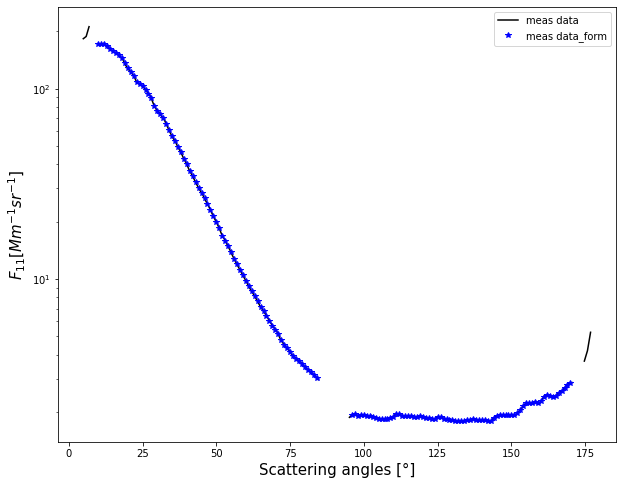

In [49]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['P11'],'k',label = 'meas data')
#plt.plot(angles_meas_new,f_11(angles_meas_new),'b*',label = 'meas data')
plt.plot(angles_NN,phase_fun_meas_form_F11.loc[0],'b*',label = 'meas data_form')

#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11'],'b',label = 'data GRASP Binned_P11')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11'],'r',label = 'data GRASP Lognormal_P11')


plt.yscale('log')

plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('$F_{11} [Mm^{-1}sr^{-1}$]', fontsize = fontsize1)
plt.legend()


(-1.0, 1.0)

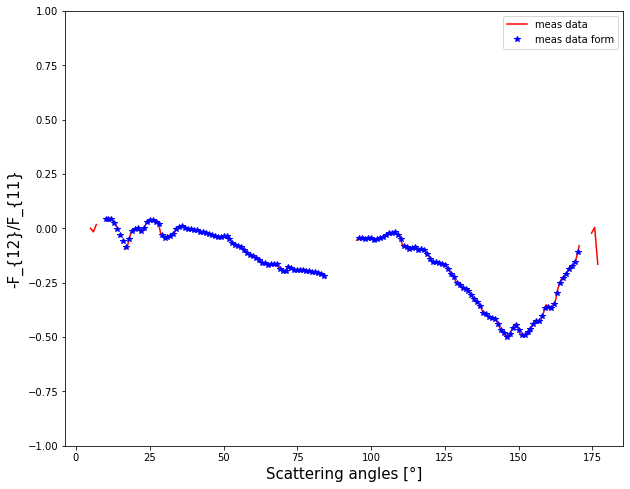

In [50]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['PPF'],'r',label = 'meas data')
plt.plot(angles_NN,phase_fun_meas_form_PPF.loc[0],'b*',label = 'meas data form')

#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11P12')


plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('-F_{12}/F_{11}', fontsize = fontsize1)
plt.legend()
plt.ylim([-1,1])

In [51]:
P11_column_names = list(filter(re.compile(".*F11").match, dvar_test.columns))
P12_column_names = list(filter(re.compile(".*PPF").match, dvar_test.columns))
P11_column_names

['F11_10',
 'F11_11',
 'F11_12',
 'F11_13',
 'F11_14',
 'F11_15',
 'F11_16',
 'F11_17',
 'F11_18',
 'F11_19',
 'F11_20',
 'F11_21',
 'F11_22',
 'F11_23',
 'F11_24',
 'F11_25',
 'F11_26',
 'F11_27',
 'F11_28',
 'F11_29',
 'F11_30',
 'F11_31',
 'F11_32',
 'F11_33',
 'F11_34',
 'F11_35',
 'F11_36',
 'F11_37',
 'F11_38',
 'F11_39',
 'F11_40',
 'F11_41',
 'F11_42',
 'F11_43',
 'F11_44',
 'F11_45',
 'F11_46',
 'F11_47',
 'F11_48',
 'F11_49',
 'F11_50',
 'F11_51',
 'F11_52',
 'F11_53',
 'F11_54',
 'F11_55',
 'F11_56',
 'F11_57',
 'F11_58',
 'F11_59',
 'F11_60',
 'F11_61',
 'F11_62',
 'F11_63',
 'F11_64',
 'F11_65',
 'F11_66',
 'F11_67',
 'F11_68',
 'F11_69',
 'F11_70',
 'F11_71',
 'F11_72',
 'F11_73',
 'F11_74',
 'F11_75',
 'F11_76',
 'F11_77',
 'F11_78',
 'F11_79',
 'F11_80',
 'F11_81',
 'F11_82',
 'F11_83',
 'F11_84',
 'F11_96',
 'F11_97',
 'F11_98',
 'F11_99',
 'F11_100',
 'F11_101',
 'F11_102',
 'F11_103',
 'F11_104',
 'F11_105',
 'F11_106',
 'F11_107',
 'F11_108',
 'F11_109',
 'F11_110',

In [52]:
np.log(phase_fun_meas_form_F11)

F11_10   F11_11   F11_12    F11_13    F11_14    F11_15    F11_16  \
0  5.14342  5.14342  5.14342  5.117309  5.091882  5.065792  5.039003   

     F11_17   F11_18    F11_19  ...   F11_161   F11_162   F11_163   F11_164  \
0  5.011476  4.97254  4.910988  ...  0.880406  0.896824  0.886325  0.872212   

    F11_165   F11_166   F11_167  F11_168   F11_169   F11_170  
0  0.891454  0.920951  0.948121  0.98563  1.025799  1.046892  

[1 rows x 150 columns]

In [53]:
# prepare the dataframes for retrieval with the different methods
phase400new5 = pd.concat([np.log(phase_fun_meas_form_F11),phase_fun_meas_form_PPF*10],axis =1)


In [54]:
phase400new5

F11_10   F11_11   F11_12    F11_13    F11_14    F11_15    F11_16  \
0  5.14342  5.14342  5.14342  5.117309  5.091882  5.065792  5.039003   

     F11_17   F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0  5.011476  4.97254  4.910988  ... -3.646084 -3.493157 -2.977155 -2.498932   

    PPF_165   PPF_166   PPF_167  PPF_168   PPF_169   PPF_170  
0 -2.281191 -2.115597 -1.864669 -1.73068 -1.551113 -1.104071  

[1 rows x 300 columns]

# Predict dvar from measurement data

In [55]:
#P11, PPF

phase400_scaled = phase400new5.copy()
phase400_scaled


F11_10   F11_11   F11_12    F11_13    F11_14    F11_15    F11_16  \
0  5.14342  5.14342  5.14342  5.117309  5.091882  5.065792  5.039003   

     F11_17   F11_18    F11_19  ...   PPF_161   PPF_162   PPF_163   PPF_164  \
0  5.011476  4.97254  4.910988  ... -3.646084 -3.493157 -2.977155 -2.498932   

    PPF_165   PPF_166   PPF_167  PPF_168   PPF_169   PPF_170  
0 -2.281191 -2.115597 -1.864669 -1.73068 -1.551113 -1.104071  

[1 rows x 300 columns]

In [56]:
dvar_pred_scaled = surr.predict(phase400_scaled.values.reshape(1,-1), batch_size = 8)
dvar_pred_scaled = pd.DataFrame(data=dvar_pred_scaled, columns=qoi_test.columns)



In [57]:
dvar_pred_scaled

Vtot  RmedianV       GSD         n    k
0  3.124627  5.474342  1.242271  1.608999  0.0

In [58]:
np.exp(5.711116)

302.20814444850976

In [59]:
dvar_pred = dvar_pred_scaled.copy()
dvar_pred['Vtot'] = np.exp(dvar_pred['Vtot'])
dvar_pred['RmedianV'] = np.exp(dvar_pred['RmedianV'])

In [60]:
dvar_pred

Vtot    RmedianV       GSD         n    k
0  22.751418  238.493577  1.242271  1.608999  0.0

In [61]:

#dvar_pred['k']=0#-dvar_pred['k']

In [62]:
'''
dvar_pred['Vtot'] = 20.406
dvar_pred['RmedianV'] = 250
dvar_pred['GSD'] = 1.2995
dvar_pred['n'] = 1.45
dvar_pred['k'] = 0.00001
dvar_pred
'''

"\ndvar_pred['Vtot'] = 20.406\ndvar_pred['RmedianV'] = 250\ndvar_pred['GSD'] = 1.2995\ndvar_pred['n'] = 1.45\ndvar_pred['k'] = 0.00001\ndvar_pred\n"

In [63]:
#phase_fun = pymiescatt_forward_prediction(dvar_pred_ps)
phase_fun1 = pymiescatt_forward_prediction(dvar_pred)


In [64]:
phase_fun1

array([ 2.04250494e+02,  2.04062093e+02,  2.03498042e+02,  2.02561784e+02,
        2.01259017e+02,  1.99597633e+02,  1.97587631e+02,  1.95241014e+02,
        1.92571661e+02,  1.89595183e+02,  1.86328764e+02,  1.82790983e+02,
        1.79001635e+02,  1.74981532e+02,  1.70752308e+02,  1.66336218e+02,
        1.61755933e+02,  1.57034343e+02,  1.52194365e+02,  1.47258750e+02,
        1.42249913e+02,  1.37189761e+02,  1.32099543e+02,  1.26999708e+02,
        1.21909783e+02,  1.16848261e+02,  1.11832513e+02,  1.06878710e+02,
        1.02001764e+02,  9.72152842e+01,  9.25315530e+01,  8.79615098e+01,
        8.35147551e+01,  7.91995644e+01,  7.50229156e+01,  7.09905262e+01,
        6.71069010e+01,  6.33753869e+01,  5.97982352e+01,  5.63766701e+01,
        5.31109603e+01,  5.00004945e+01,  4.70438591e+01,  4.42389163e+01,
        4.15828825e+01,  3.90724056e+01,  3.67036408e+01,  3.44723239e+01,
        3.23738413e+01,  3.04032971e+01,  2.85555756e+01,  2.68254004e+01,
        2.52073888e+01,  

In [65]:
name = []
for i in range(180):
    name.append('F11_'+str(i))    
for i in range(180):
    name.append('PPF_'+str(i))

In [66]:
phase_fun1 = pd.DataFrame(phase_fun1.reshape(1,-1),columns= name)

In [67]:
F11_list1 = [x for x in phase_fun1.columns if 'F11' in x]
PPF_list1 = [x for x in phase_fun1.columns if 'PPF' in x]
angles = np.arange(0,180,1)

In [68]:
angles_new  = np.arange(0,180)


In [69]:
len(angles_NN)

150

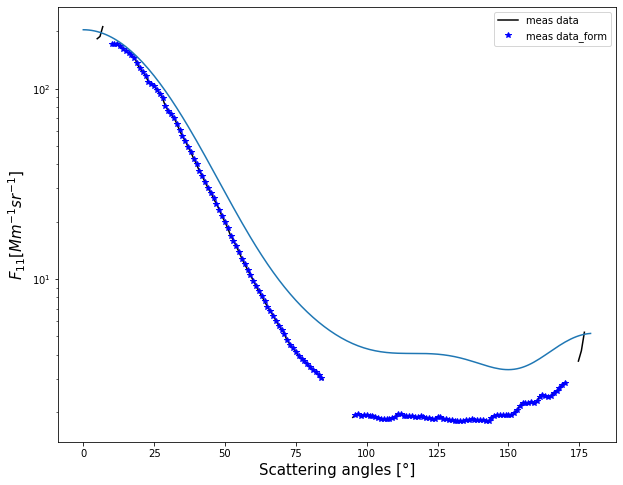

In [70]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['P11'],'k',label = 'meas data')
#plt.plot(angles_meas_new,f_11(angles_meas_new),'b*',label = 'meas data')
plt.plot(angles_NN,phase_fun_meas_form_F11.loc[0],'b*',label = 'meas data_form')
#plt.plot(angles_NN, np.exp(qoi_pred_test[F11_list].loc[0]), label='predicted')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_Binned (0.05-15$\mu$m)_P11'],'b',label = 'data GRASP Binned_P11')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['P11_lognormal (0.05-15$\mu$m)_P11'],'r',label = 'data GRASP Lognormal_P11')

plt.plot(angles, phase_fun1[F11_list1].values[0])
#plt.plot(angles, phase_fun2[F11_list1].values[0])

plt.yscale('log')

plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('$F_{11} [Mm^{-1}sr^{-1}$]', fontsize = fontsize1)
plt.legend()


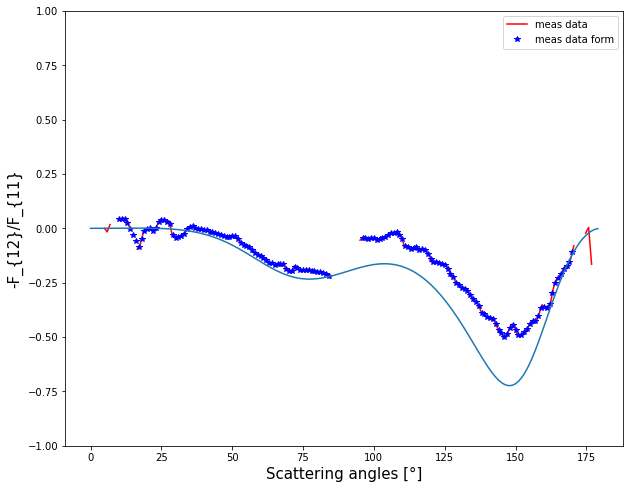

In [71]:
fontsize1 = 15
plt.figure(figsize= (10,8))
plt.plot(phase_fun_meas['angles'],phase_fun_meas['PPF'],'r',label = 'meas data')
plt.plot(angles_NN,phase_fun_meas_form_PPF.loc[0],'b*',label = 'meas data form')
#plt.plot(angles_NN, qoi_pred_test[PPF_list].loc[0]/10, label='predicted')

#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_Binned (0.05-15$\mu$m)_P11P12'],'c',label = 'data GRASP Binned_P11P12')
#plt.plot(phase_fun_GRASP_inv['angle'],phase_fun_GRASP_inv['PPF_lognormal (0.05-15$\mu$m)_P11P12'],'m',label = 'data GRASP Lognormal_P11P12')
plt.plot(angles, phase_fun1[PPF_list1].values[0])
#plt.plot(angles, phase_fun2[PPF_list1].values[0])

plt.xlabel('Scattering angles [°]', fontsize = fontsize1)
plt.ylabel('-F_{12}/F_{11}', fontsize = fontsize1)
plt.ylim([-1,1])
plt.legend()

# Compare to true values

In [72]:
r_vol = np.linspace(0.05,5, 500)


In [73]:
dvar_pred

Vtot    RmedianV       GSD         n    k
0  22.751418  238.493577  1.242271  1.608999  0.0

In [74]:
D_median_V = dvar_pred['RmedianV']*2  # [nm]
D_median_N = (np.exp(np.log(D_median_V) - (3*np.log(dvar_pred['GSD'])**2)))       
GSD = dvar_pred['GSD']
V_tot = dvar_pred['Vtot']
testnr = 10
lower = D_median_V/GSD/testnr
upper = D_median_V*GSD*testnr

D_array = np.logspace(np.log10(lower),np.log10(upper),301)

N_tot = 6 / np.pi * V_tot*1e9 / (np.exp((3*np.log(D_median_N)) + (4.5*np.log(GSD)**2))) # [cm^-3]


In [75]:
def lognormal(D_array, D_median, GSD, Ntot):  # dn/dD
    n = (Ntot/(np.sqrt(2*np.pi)*(np.log(GSD)))/D_array) * np.exp(-(np.log(D_array)-np.log(D_median))**2/(2*(np.log(GSD)**2)))   # nm-1 * cm-3
    return n


In [76]:
dvar_pred

Vtot    RmedianV       GSD         n    k
0  22.751418  238.493577  1.242271  1.608999  0.0

In [77]:
N_tot

0    494.843021
dtype: float64

In [78]:
n = lognormal(vol_size_meas['r (um)'].values*1e3, D_median_N.values[0], GSD.values[0], N_tot.values[0])


In [79]:
D_array   
                    

array([[  38.39636996],
       [  39.04675473],
       [  39.70815616],
       [  40.38076088],
       [  41.06475865],
       [  41.76034246],
       [  42.46770856],
       [  43.18705652],
       [  43.9185893 ],
       [  44.6625133 ],
       [  45.41903841],
       [  46.18837808],
       [  46.97074936],
       [  47.766373  ],
       [  48.57547347],
       [  49.39827906],
       [  50.23502191],
       [  51.08593809],
       [  51.9512677 ],
       [  52.83125487],
       [  53.72614787],
       [  54.63619921],
       [  55.56166564],
       [  56.50280827],
       [  57.45989264],
       [  58.43318877],
       [  59.42297128],
       [  60.42951943],
       [  61.4531172 ],
       [  62.49405338],
       [  63.55262168],
       [  64.62912075],
       [  65.72385432],
       [  66.83713126],
       [  67.96926567],
       [  69.12057697],
       [  70.29138999],
       [  71.48203507],
       [  72.69284813],
       [  73.9241708 ],
       [  75.17635048],
       [  76.449

In [80]:
vol_size_meas['r (um)'].values*1e3

array([ 65.5 ,  67.9 ,  70.35,  72.95,  75.6 ,  78.4 ,  81.25,  84.25,
        87.35,  90.55,  93.85,  97.3 , 100.85, 104.55, 108.35, 112.35,
       116.45, 120.7 , 125.15, 129.75, 134.5 , 139.4 , 144.5 , 149.8 ,
       155.3 , 161.  , 166.9 , 173.  , 179.35, 185.9 , 192.7 , 199.75,
       207.1 , 214.7 , 222.55, 230.7 , 239.15, 247.9 , 257.  , 266.4 ,
       276.15, 286.25, 296.75, 307.65, 318.9 , 330.6 , 342.7 , 355.25,
       368.25, 381.75, 395.75, 410.25, 425.25, 440.85, 457.  , 473.75])

Text(0.5, 1.0, '$v=Vtot/(\\sqrt{2\\pi}\\log(\\sigma))*\\exp{[-(\\log(x)-\\log(\\mu))^2/(2(\\log(\\sigma))^2)]}$')

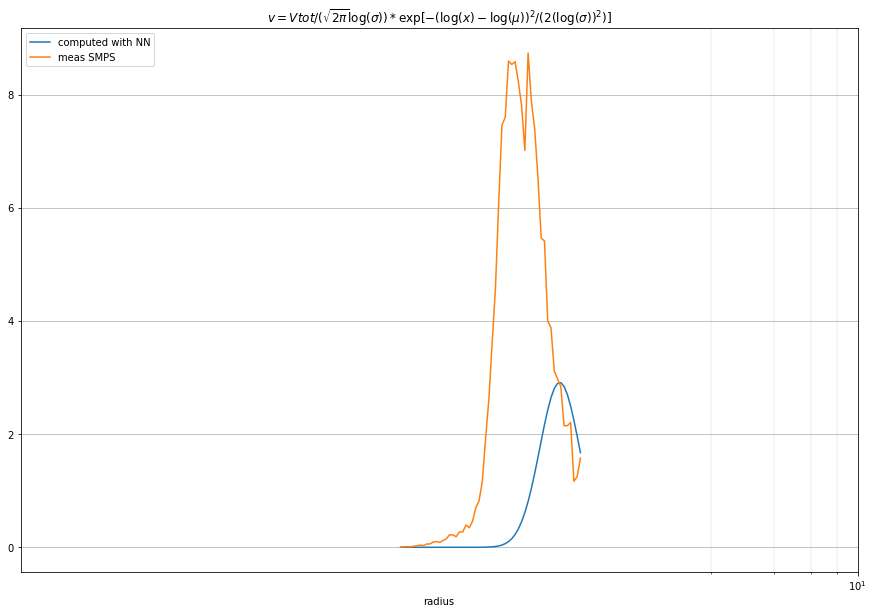

In [81]:
figure, ax = plt.subplots(1,1, figsize = [15, 10])
#ax.plot(vol_size_GRASP_log['r (um)'],vol_size_GRASP_log['lognormal (0.05-15$\mu$m)_P11P12'], label = 'GRASP log P11P12')
#ax.plot(vol_size_GRASP_log['r (um)'],vol_size_GRASP_log['lognormal (0.05-15$\mu$m)_P11'], label = 'GRASP log P11P12')

ax.plot(vol_size_meas['r (um)'], n/(2*vol_size_meas['r (um)']), label='computed with NN' )
#ax.plot(r_vol,vol_size_GRASP_P11P12_log, label='computed with GRASP_P11P12_log' )
#ax.plot(r_vol,vol_size_P11P12_INN, label='computed with rP11P12_INN' )
#ax.plot(r_vol,vol_size_P11_INN, label='computed with P11_INN' )
#ax.plot(r_vol,vol_size_P12_INN, label='computed with P12_INN' )




ax.plot(vol_size_meas['r (um)'], vol_size_meas['dV/dlogr'], label="meas SMPS")






ax.set_xlim([0.001, 10])
ax.set_xscale('log')
ax.xaxis.set_major_locator(plt.MultipleLocator(10))
ax.xaxis.set_minor_locator(plt.MultipleLocator(2))
ax.grid(b=True, which = 'major', linewidth = 0.75)
ax.grid(b=True, which = 'minor', linewidth = 0.25)    

ax.legend(ncol = 1, loc = 'upper left')#, bbox_to_anchor = (1,1.15), fontsize = 12)
ax.set_xlabel('radius')
#ax.set_ylabel('volume size distribution')

ax.set_title('$v=Vtot/(\sqrt{2\pi}\log(\sigma))*\exp{[-(\log(x)-\log(\mu))^2/(2(\log(\sigma))^2)]}$')





NameError: name 'vol_size_dvar' is not defined

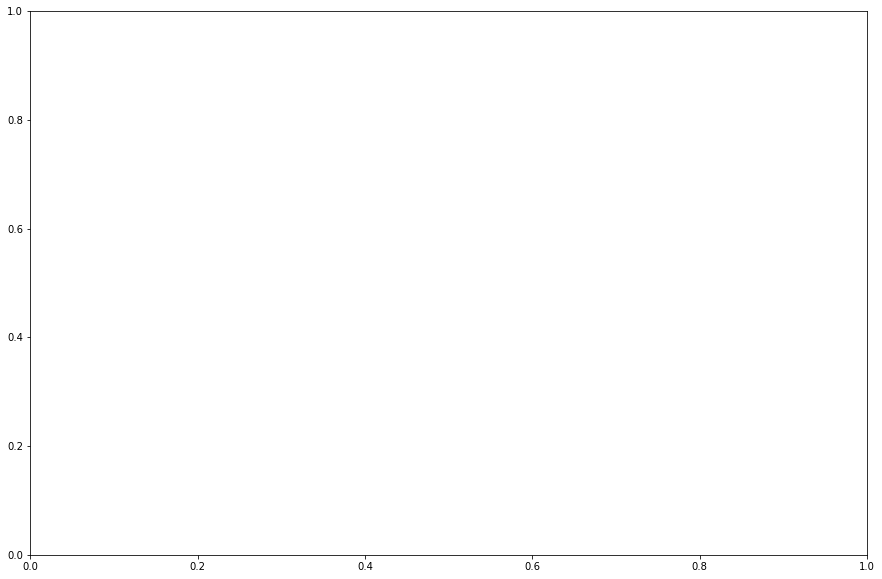

In [82]:
figure, ax = plt.subplots(1,1, figsize = [15, 10])

ax.plot(r_vol,vol_size_dvar, label='computed with FNN' )
